# Serialise Detections to a CSV File

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow/supervision/blob/develop/docs/notebooks/detections-to-jsonsink.ipynb)

This cookbook introduce [sv.CSVSink](https://supervision.roboflow.com/latest/detection/tools/save_detections/#supervision.detection.tools.csv_sink.CSVSink) tool designed to write captured object detection data to file from video streams/file

Click the `Open in Colab` button to run the cookbook on Google Colab.

In [ ]:
!pip install -q inference requests tqdm supervision==0.21.0

In [1]:
import csv
from typing import List
from collections import defaultdict

import numpy as np
import pandas as pd

import supervision as sv
from supervision.assets import download_assets, VideoAssets
from inference import InferencePipeline
from inference.core.interfaces.camera.entities import VideoFrame


The parameters defined below are:
* `SOURCE_VIDEO_PATH` - the path to the input video
* `CONFIDENCE_THRESHOLD` - do not include detections below this confidence level
* `IOU_THRESHOLD` - discard detections that overlap with others by more than this [IOU](https://blog.roboflow.com/how-to-code-non-maximum-suppression-nms-in-plain-numpy/) ratio
* `FILE_NAME` - write the json output to this file
* `INFERENCE_MODEL` - model id. This cookbook uses a [model alias](https://inference.roboflow.com/quickstart/aliases/), but it can also be a [fine-tuned model](https://inference.roboflow.com/quickstart/explore_models/) or a model from the [Universe](https://inference.roboflow.com/quickstart/load_from_universe/).

In [2]:
SOURCE_VIDEO_PATH = download_assets(VideoAssets.PEOPLE_WALKING)
CONFIDENCE_THRESHOLD = 0.3
IOU_THRESHOLD = 0.7
FILE_NAME = "detections.csv"
INFERENCE_MODEL = "yolov8n-640"

people-walking.mp4 asset download complete. 



As a result of executing the above `download_assets(VideoAssets.PEOPLE_WALKING)` , you will download a video file and save it at the `SOURCE_VIDEO_PATH`. Keep in mind that the video preview below works only in the web version of the cookbooks and not in Google Colab.

<video controls width="1280">
  <source src="https://media.roboflow.com/supervision/video-examples/people-walking.mp4" type="video/mp4">
</video>


## Read single frame from video

The [`get_video_frames_generator`](https://supervision.roboflow.com/develop/utils/video/#supervision.utils.video.get_video_frames_generator) enables us to easily iterate over video frames. Let's create a video generator for our sample input file and display its first frame on the screen.


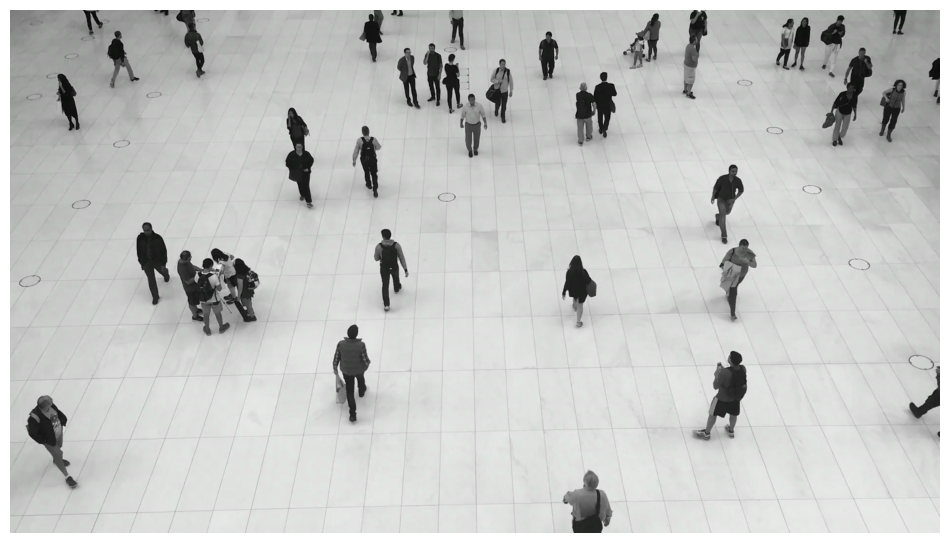

In [3]:
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(generator)

sv.plot_image(frame, (12, 12))

## Initialize ByteTrack

[ByteTrack](https://supervision.roboflow.com/latest/trackers/#bytetrack) is a multi-object tracking algorithm used by Supervision to track and link detected objects across multiple frames, providing consistent IDs for each object.Initialize the  object.

In [5]:
byte_track = sv.ByteTrack()
byte_track.reset()

## Initialize CSVSink

To save detections to a `CSV` file, open our [`sv.CSVSink`](https://supervision.roboflow.com/latest/how_to/save_detections/#save-detections-as-csv) and then pass the [`sv.Detections`](https://supervision.roboflow.com/latest/detection/core/#detections) object resulting from the inference to it.

Note that empty detections will be skipped.

In [6]:
csv_sink = sv.CSVSink(FILE_NAME)
csv_sink.open()

## Process video and save detections to csv file

The [`InferencePipeline`](https://inference.roboflow.com/using_inference/inference_pipeline/) interface is made for streaming and is likely the best route to go for real time use cases. It is an asynchronous interface that can consume many different video sources including local devices (like webcams), RTSP video streams, video files, etc. With this interface, you define the source of a video stream and sinks.

All the operations we plan to perform for each frame of our video - detection, tracking, annotation, and write to csv are encapsulated in a function named `callback`.

In [7]:
def callback(predictions: dict, frame: VideoFrame) -> np.ndarray:
    detections = sv.Detections.from_inference(predictions)
    detections = detections[detections.class_id == 0]
    detections = byte_track.update_with_detections(detections)
    csv_sink.append(detections, custom_data={'frame_number': frame.frame_id})

In [8]:
pipeline = InferencePipeline.init(
    model_id=INFERENCE_MODEL,
    video_reference=SOURCE_VIDEO_PATH,
    on_prediction=callback,
    iou_threshold=IOU_THRESHOLD,
    confidence=CONFIDENCE_THRESHOLD,
)

In [9]:
pipeline.start()
pipeline.join()

In [10]:
csv_sink.close()

## Visualizate results of detections csv data with Pandas

Let's take a look at our resulting data with by using Pandas.

It will also be created in your current directory with the name detections.csv as well.

In [11]:
df = pd.read_csv(FILE_NAME)
df

,x_min,y_min,x_max,y_max,class_id,confidence,tracker_id,frame_number
0,1460.000000,469.00000,1544.00000,641.00000,0,0.805656,1,1
1,1447.000000,320.00000,1516.00000,480.00000,0,0.786558,2,1
2,1142.000000,950.00000,1245.00000,1080.00000,0,0.767850,3,1
3,259.000000,435.00000,326.00000,610.00000,0,0.765763,4,1
4,665.000000,649.00000,744.00000,851.00000,0,0.765134,5,1
...,...,...,...,...,...,...,...,...
9024,391.778870,470.54680,461.86307,632.92175,0,0.466400,97,341
9025,1012.071800,59.12985,1052.57750,174.31790,0,0.403422,99,341
9026,1854.523700,259.76390,1914.65420,442.42612,0,0.719575,100,341
9027,74.071335,700.19543,173.33969,893.13947,0,0.416318,84,341


## Convert CSV data to sv.Detections

In [13]:
def csv_to_detections(csv_file: str) -> List[sv.Detections]:
    rows_by_frame_number = defaultdict(list)
    with open(csv_file, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            frame_number = int(row["frame_number"])
            rows_by_frame_number[frame_number].append(row)

    detections_list = []
    for frame_number, rows in rows_by_frame_number.items():
        xyxy = []
        class_id = []
        confidence = []
        tracker_id = []
        custom_data = defaultdict(list)

        for row in rows:
            xyxy.append([row[key] for key in ["x_min", "y_min", "x_max", "y_max"]])
            class_id.append(row["class_id"])
            confidence.append(row["confidence"])
            tracker_id.append(row["tracker_id"])

            for custom_key in row.keys():
                if custom_key in ["x_min", "y_min", "x_max", "y_max", "class_id", "confidence", "tracker_id"]:
                    continue
                custom_data[custom_key].append(row[custom_key])

        if all([val == "" for val in class_id]):
            class_id = None
        if all([val == "" for val in confidence]):
            confidence = None
        if all([val == "" for val in tracker_id]):
            tracker_id = None

        detections_list.append(
            sv.Detections(
                xyxy=np.array(xyxy, dtype=np.float32),
                class_id=np.array(class_id, dtype=int),
                confidence=np.array(confidence, dtype=np.float32),
                tracker_id=np.array(tracker_id, dtype=int),
                data=dict(custom_data)
            )
        )
    
    return detections_list

In [15]:
detections_list = csv_to_detections(FILE_NAME)
detections_list

[Detections(xyxy=array([[1460.,  469., 1544.,  641.],
        [1447.,  320., 1516.,  480.],
        [1142.,  950., 1245., 1080.],
        [ 259.,  435.,  326.,  610.],
        [ 665.,  649.,  744.,  851.],
        [ 750.,  450.,  823.,  620.],
        [1794.,  144., 1851.,  272.],
        [1202.,  128., 1255.,  263.],
        [ 710.,  242.,  765.,  387.],
        [ 199.,   44.,  265.,  161.],
        [1091.,   46., 1133.,  148.],
        [1419.,  702., 1526.,  887.],
        [1674.,   12., 1727.,  141.],
        [ 566.,  271.,  629.,  405.],
        [  32.,  793.,  137.,  990.],
        [1616.,   18., 1655.,  127.],
        [1163.,  151., 1214.,  280.],
        [  90.,  129.,  145.,  253.],
        [ 925.,  175.,  980.,  307.],
        [ 892.,   94.,  931.,  211.],
        [ 799.,   76.,  844.,  203.],
        [ 854.,   73.,  894.,  197.],
        [1695.,   78., 1781.,  284.],
        [1580.,   19., 1622.,  123.],
        [ 726.,    9.,  770.,  109.]], dtype=float32), mask=None, confid

### Annotate First Frame

Visualize the first frame of a video alongside the initial detections obtained by parsing CSV data into [`sv.Detections`](https://supervision.roboflow.com/latest/detection/core/#detections) objects. The annotated image will show the original video frame, marked with the first bounding box detected from the parsed data, providing a visual representation of the identified object(s) in the scene.

### Get back `sv.Detections`

In [16]:
FRAME_NUMBER = 100

detections = detections_list[FRAME_NUMBER]
frame_number = detections.data["frame_number"][0]


generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH, start=FRAME_NUMBER)
frame = next(generator)

### Annotate Image with Detections

Finally, we can annotate the image with the predictions. Since we are working with an object detection model, we will use the [`sv.BoundingBoxAnnotator`](https://supervision.roboflow.com/latest/detection/annotators/#supervision.annotators.core.BoundingBoxAnnotator) and [`sv.LabelAnnotator`](https://supervision.roboflow.com/latest/detection/annotators/#supervision.annotators.core.LabelAnnotator) classes.

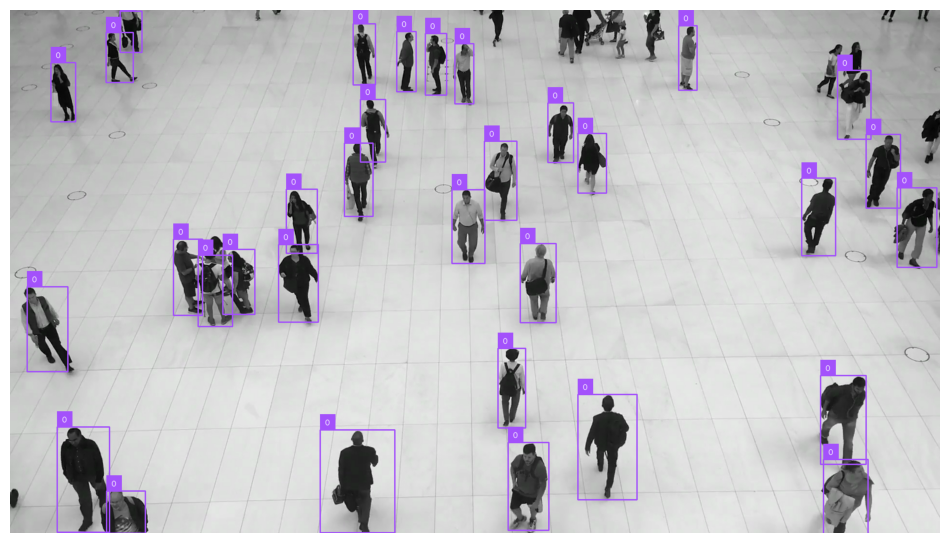

In [17]:
bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_frame = frame.copy()
annotated_frame = bounding_box_annotator.annotate(scene=annotated_frame, detections=detections)
annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections)
sv.plot_image(annotated_frame, (12, 12))

## References 📚

* Supervision: https://supervision.roboflow.com
* sv.Detections: https://supervision.roboflow.com/develop/detection/core/#detections
* Save Detections to CSV: https://supervision.roboflow.com/develop/how_to/save_detections/#save-detections-as-csv
* Custom fields: https://supervision.roboflow.com/develop/how_to/save_detections/#custom-fields
* ByteTrack: https://supervision.roboflow.com/trackers/#supervision.tracker.byte_tracker.core.ByteTrack
* Inference: https://inference.roboflow.com/
* Inference Pipeline: https://inference.roboflow.com/using_inference/inference_pipeline/
* Inference Aliases: https://inference.roboflow.com/quickstart/aliases/

